<a href="https://colab.research.google.com/github/alexmplastow/IE534-CS547-Emmerson/blob/main/LinearRegression_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download the dataset

In [ ]:
!wget -c https://data.cdc.gov/api/views/xkb8-kh2a/rows.csv?accessType=DOWNLOAD&bom=true&format=true -O Drug_Overdose_Deaths.csv #name did not changed...

/bin/bash: -O: command not found
--2022-12-09 04:18:19--  https://data.cdc.gov/api/views/xkb8-kh2a/rows.csv?accessType=DOWNLOAD
Resolving data.cdc.gov (data.cdc.gov)... 52.206.140.199, 52.206.68.26, 52.206.140.205
Connecting to data.cdc.gov (data.cdc.gov)|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv?accessType=DOWNLOAD’

rows.csv?accessType     [     <=>            ]   9.20M  8.95MB/s    in 1.0s    

2022-12-09 04:18:20 (8.95 MB/s) - ‘rows.csv?accessType=DOWNLOAD’ saved [9651249]



# Importing necessary Modules

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.autograd import Variable

import matplotlib.pyplot as plt

# Function Declarations

Functions are stored in a seperate block

Comments are added to indicate what goes into the function and what comes out, so they may be treated as black boxes

Two usefull functions are defined here: one for converting categorical data into one of the numeric data types and another for normalizing a specified pandas column

In [ ]:
#I borrowed this function from another project, it does not generalize
#to pandas dataframes, so
#Input: data frame (we use an nd.array object here), labels (also nd.array), and the division of folds
#Output: partitioned arrays paired in tuples
def partition(X, Y, partitionsInPercent):
  inputDimensions = X.shape

  if sum(partitionsInPercent) != 100:
    raise Exception('You are not entering fold sizes which add'
                    'to 100%, enter the k-fold percent, '
                    'the validation percent, and the testing percent')
  fractionCovered = 0
  partitions = []

  for partitionSizeInPercent in partitionsInPercent:
    alpha = int((fractionCovered) * inputDimensions[0])
    omega = int((fractionCovered + partitionSizeInPercent /
                 100) * inputDimensions[0])
    dataRange = range(alpha, omega)
    fractionCovered += partitionSizeInPercent / 100
    partitions.append(tuple((X[dataRange, :], Y[dataRange,])))

  return partitions

#Input, dataframe which you wish to encode for one column
#Output, the same dataframe with an encoding for a single column
def categoricalEncoding(category, df):
  Encoder = dict([(j, i) for i,j in enumerate(list(set(df[category])))])
  Encoding = pd.Series([Encoder[state] for state in df[category]])
  df[category] = Encoding
  return df

#Input: column for normalization and the dataframe
#Output: The same dataframe, just with the specified column normalized
columnNormalization = lambda column, df : \
                      (df[column] - df[column].min())  \
                      / (df[column].max() - df[column].min())

# Data Processing

This is where most of the dataframe manipulation is done

Data is uploaded, useless data is dropped, NaN values are removed, categorical data is encoded, dataframes are split into inputs and outputs, and dataframes are converted into pytorch tensors

In [ ]:
df = pd.read_csv('rows.csv?accessType=DOWNLOAD').dropna().reset_index()

#I see in the "DataPreProcessing&Visualization.py" script, there was an action to drop useless features
#I haven't combed through them all, but I'm going to trust my teammates
#judgement


df = df.drop(labels=["State Name", "Period", "Percent Complete", "Footnote",
                     "Footnote Symbol", "Predicted Value"], axis=1) #"Percent Pending Investigation", 

#I am operating under the not entirely unreasonable assumption that
  #'Data Value' produces the "predicted values" by using the other parameters
  #to train a prediction for the "Predicted Value" column

outputDf = pd.DataFrame(df['Data Value'], columns=["Data Value"])
inputDf = df.drop(labels=['Data Value'], axis = 1)

#Encoding the data
  #I opted not to use one-hot encoding, I figured fifty categorical variables
  #Wouldn't improve the quality of the learning algorithm
  #But I certainly wouldn't mind if somebody proved me wrong

#It looks to me like the data is encoded properly

for category in ["State", "Month", "Indicator"]:
  inputDf = categoricalEncoding(category, inputDf)

for category in ["State", "Month", "Year", "Indicator"]:
  inputDf[category] = columnNormalization(category, inputDf)

inputDf = inputDf.drop(columns='index')

#I had to add this abomination to get the code running
#outputDf["Data Value"] = \
#    pd.Series([float(string.replace(',','')) for string in outputDf["Data Value"]])


outputDf["Data Value"] = columnNormalization("Data Value", outputDf)

inputArray = np.array(inputDf)
outputArray = np.array(outputDf).reshape(len(outputDf), 1)

inputTensor = torch.from_numpy(inputArray).unsqueeze(dim=0).type(torch.double)
outputTensor = torch.from_numpy(outputArray).unsqueeze(dim=0).type(torch.double)

partitions = partition(inputArray, outputArray, [20, 20, 20, 20, 20])




# Linear Regression Model

I borrowed a goodly portion of the code from a tutorial at https://www.geeksforgeeks.org/linear-regression-using-pytorch/ 

In [ ]:
class LinearRegressionModel(torch.nn.Module):

    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(5, 1)  # Five in and one out

    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred

Training loop, the model appears to have fitted the data, judging by the graph

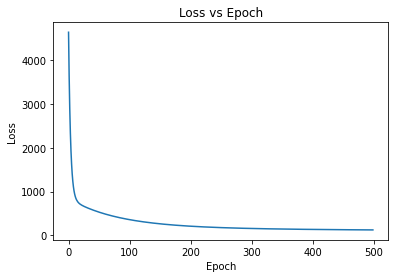

In [ ]:
#Defining an instance of the model
our_model = LinearRegressionModel()

EPOCH = 500
#The losses are calculated for each batch if the size_average boolean is set
  #to false
criterion = torch.nn.MSELoss(size_average = False)

#I had too lower the learning rate to avoid exploring ridiculous parameter spaces
optimizer = torch.optim.SGD(our_model.parameters(), lr = 0.000001)

losses = []
for epoch in range(EPOCH):

	#Calculating the prediction space based on model parameters
	pred_y = our_model(inputTensor.float())

	# Computing loss
	loss = criterion(pred_y, outputTensor.float())

  #The "zero_grad()" method  clears data on the gradient
    #We want to recalculate the gradient at every go
	optimizer.zero_grad()

  #Weights are updated here, a step is taken on the plane of possible
    #parameter combinations

	loss.backward()
	optimizer.step()

  #I store the losses to graph later
	losses.append(loss.item())

plt.plot(list(range(0,EPOCH)), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.show()

In [ ]:
loss_df = pd.DataFrame()

In [ ]:
loss_df["LinearRegression_losses"] = losses

In [ ]:
loss_df

,LinearRegression_losses
0,4634.988281
1,3629.376953
2,2886.292969
3,2336.681641
4,1929.659180
...,...
495,127.381073
496,127.294838
497,127.209030
498,127.123642


In [ ]:
loss_df.to_csv("LinearRegression_losses.csv")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
min(losses)

127.0386734008789